In [26]:
# importing necessary packages

import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score

import pickle

In [27]:
# setting a seed

seed = 42
np.random.seed(seed)

In [28]:
# defining paths

train_dir  = "data/train/final_data/"
meta_dir   = "saved_cc_metadata"

os.makedirs(meta_dir, exist_ok=True) # to store working files

x_path      = os.path.join(train_dir, "X_train.npy")
y_bp_path   = os.path.join(train_dir, "Y_bp_train.npy")

cc_keep_npy    = os.path.join(meta_dir, "cc_keep.npy")
go_cc_map_pkl  = os.path.join(meta_dir, "go_cc_map.pkl")
CC_model_path  = os.path.join(meta_dir, "cc_model.h5")
scaler_path    = os.path.join(meta_dir, "embed_scaler.pkl")

In [29]:
# loading data

X      = np.load(x_path)      # preprocessed training data = (123696,2024)
Y_bp   = np.load(y_bp_path)   # CC training labels         = (123969, 677)

print("X:", X.shape, "Y_bp:", Y_bp.shape) #checkpoint

X: (123969, 2024) Y_bp: (123969, 1466)


In [30]:
interpro_dim = 1000
embeded_dim = X.shape[1] - interpro_dim
assert embeded_dim > 0, "Embedding dimension inferred <= 0; check interpro_dim."

X_domains = X[:, :interpro_dim].astype(np.float32)  # keep as 0/1 float
X_embed   = X[:, interpro_dim:].astype(np.float32)

In [31]:
# BP label filtering

use_bp_mask = True # can be turned of, not recommended
if use_bp_mask:
    mask = (Y_bp.sum(axis=1) > 0)
    X_domains = X_domains[mask]
    X_embed   = X_embed[mask]
    Y_bp      = Y_bp[mask]
    print("After CC mask, X:", (X_domains.shape[0], X_domains.shape[1] + X_embed.shape[1]), "Y:", Y_bp.shape)

After CC mask, X: (83064, 2024) Y: (83064, 1466)


In [32]:
mask

array([ True, False, False, ...,  True,  True,  True])

In [33]:
# Feature normalization

scaler = StandardScaler()
X_embed_scaled = scaler.fit_transform(X_embed)

with open(scaler_path, "wb") as f:
    pickle.dump(scaler, f)

X_scaled = np.concatenate([X_domains, X_embed_scaled], axis=1) # reassembling matrix

In [34]:
# train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, Y_bp, test_size=0.15, random_state=seed
)

y_train = y_train.astype(np.float32)
y_val   = y_val.astype(np.float32)

print("Train:", X_train.shape, y_train.shape, "Val:", X_val.shape, y_val.shape)

Train: (70604, 2024) (70604, 1466) Val: (12460, 2024) (12460, 1466)


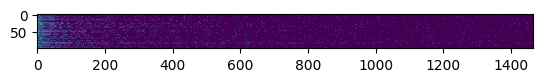

In [35]:
import matplotlib.pyplot as plt
plt.imshow(Y_bp[0:100])
plt.show()

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [37]:
batch_size = X_train.shape[0] // 100

In [38]:
import math

In [39]:
class ModelConvAdditive(nn.Module):
  def __init__(self):
    super(ModelConvAdditive, self).__init__()
    self.conv_pipeline = nn.Sequential(
        nn.Conv1d(1, 1, 3, 1, "same"),
        nn.Conv1d(1, 1, 3, 1, "same")
    )
    self.ff1_layer = nn.Sequential(
        nn.Linear(2024, 1024),
        nn.BatchNorm1d(1024),
        nn.LeakyReLU(),
        nn.Dropout(0.15)
    )
    self.ff2_layer = nn.Sequential(
        nn.Linear(1024, 1024),
        nn.BatchNorm1d(1024),
        nn.LeakyReLU(),
        nn.Dropout(0.15)
    )
    self.ff3_layer = nn.Sequential(
        nn.Linear(1024, 1024),
        nn.BatchNorm1d(1024),
        nn.LeakyReLU(),
        nn.Dropout(0.15)
    )
    self.ff4_layer = nn.Linear(1024, 1466)

  def forward(self, x):
    # Create convoluted version of input to add to first layer's input
    x_convoluted = x.unsqueeze(1)
    x_convoluted = self.conv_pipeline(x_convoluted)
    x_convoluted = x_convoluted.squeeze(1)

    x = self.ff1_layer(x + x_convoluted)

    # Create convoluted version of first layer output to add to second layer's input
    x_convoluted = x.unsqueeze(1)
    x_convoluted = self.conv_pipeline(x_convoluted)
    x_convoluted = x_convoluted.squeeze(1)

    x = self.ff2_layer(x + x_convoluted)

    # Create convoluted version of second layer output to add to third layer's input
    x_convoluted = x.unsqueeze(1)
    x_convoluted = self.conv_pipeline(x_convoluted)
    x_convoluted = x_convoluted.squeeze(1)

    x = self.ff3_layer(x + x_convoluted)

    # Create convoluted version of third layer output to add to fourth layer's input
    x_convoluted = x.unsqueeze(1)
    x_convoluted = self.conv_pipeline(x_convoluted)
    x_convoluted = x_convoluted.squeeze(1)

    x = self.ff4_layer(x + x_convoluted)
    
    return x

In [40]:
modelconv = ModelConvAdditive()
modelconv_path = train_dir + "/modelconv_add.pth"
if os.path.exists(modelconv_path):
     modelconv.load_state_dict(torch.load(modelconv_path))
criterionconv = nn.BCEWithLogitsLoss()
optimizerconv = torch.optim.Adam(modelconv.parameters(), lr=0.001)

C:\Users\Tryerand Retryer\AppData\Local\Temp\ipykernel_15580\2318345273.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  modelconv.load_state_dict(torch.load(modelconv_pa

In [41]:
y_train

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       ...,
       [1., 1., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [47]:
best_loss = math.inf
for epoch in range(50):
  print("Ep " + str(epoch / 50))
  for b in range(100):
    batch = torch.tensor(X_train[batch_size * b : batch_size * (b + 1), :])
    Y_pred = modelconv(batch)
    Y_true = torch.tensor(y_train[batch_size * b : batch_size * (b + 1), :])
    loss = criterionconv(Y_pred, Y_true)
    optimizerconv.zero_grad()
    loss.backward()
    optimizerconv.step()
    curr_loss = loss.item()
    print(curr_loss)
    if curr_loss < best_loss:
      best_loss = curr_loss
      torch.save(modelconv.state_dict(), modelconv_path)

Ep 0.0
0.028228197246789932
0.030847741290926933
0.02876485325396061
0.031898241490125656
0.02889666147530079
0.0287324171513319
0.030589397996664047
0.028734305873513222
0.030625322833657265
0.028876781463623047
0.030467703938484192
0.03206108137965202
0.029362792149186134
0.02994944155216217
0.030256953090429306
0.03126551955938339
0.028827503323554993
0.03103548474609852
0.02975190430879593
0.02893952466547489
0.029303990304470062
0.02893867902457714
0.029679693281650543
0.02884592115879059
0.03325875476002693
0.029508022591471672
0.030611025169491768
0.02841033786535263
0.029438262805342674
0.03193804249167442
0.027842558920383453
0.029361851513385773
0.02841821312904358
0.029544426128268242
0.030105967074632645
0.027938799932599068
0.02835843712091446
0.02899547852575779
0.029252955690026283
0.030744746327400208
0.030945824459195137
0.03183182701468468
0.029857952147722244
0.03160099312663078
0.029950814321637154
0.028054414317011833
0.030037174001336098
0.031609732657670975
0.028

In [48]:
val_prob_conv = modelconv(torch.tensor(X_val)).detach().numpy()
print(val_prob_conv.shape)

(12460, 1466)


In [49]:
# defininf micro f1

def micro_f1(y_true, y_prob, thr):
    y_pred = (y_prob >= thr).astype(np.int8)
    tp = (y_pred * y_true).sum()
    fp = (y_pred * (1 - y_true)).sum()
    fn = ((1 - y_pred) * y_true).sum()
    if tp == 0:
        return 0.0
    precision = tp / (tp + fp + 1e-9)
    recall    = tp / (tp + fn + 1e-9)
    return float(2 * precision * recall / (precision + recall + 1e-9))

In [50]:
# threshold scan on validation set

thresholds = np.arange(0.05, 0.51, 0.01)

best_thr_conv, best_score_conv = None, -1.0
for t in thresholds:
    s = micro_f1(y_val, val_prob_conv, t)
    if s > best_score_conv:
        best_score_conv = s
        best_thr_conv = t

print("Best threshold conv (micro-F1 scan):", best_thr_conv, "score:", best_score_conv)

Best threshold conv (micro-F1 scan): 0.05 score: 0.46751049160957336


In [ ]:
best_score_conv

0.45974844694137573